In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

## Data Ingestion

In [2]:
# Baixamos o dataset caso ele não exista
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

if not os.path.isfile("./data/cifar10"):
    download_url(dataset_url, ".")

Using downloaded and verified file: .\cifar10.tgz


In [3]:
# Extraimos o arquivo caso ele não exista

if not os.path.isdir("./data/cifar10"):
    with tarfile.open("./cifar10.tgz", "r:gz") as tar:
        tar.extractall(path="./data")

## Data Validation

In [4]:
data_dir = "./data/cifar10"

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Data Transformation

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [6]:
dataset = ImageFolder(data_dir + "/train", transform=ToTensor())

In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [8]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [10]:
def show_example(img, label):
    print("Label: ", dataset.classes[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


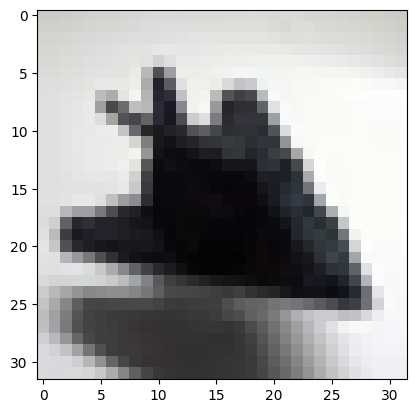

In [11]:
show_example(*dataset[0])

## Treinamento e Validação

In [12]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED);

In [13]:
VAL_SIZE = 5000
train_size = len(dataset) - VAL_SIZE

train_ds, val_ds = random_split(dataset, [train_size, VAL_SIZE])
len(train_ds), len(val_ds)

(45000, 5000)

In [14]:
from torch.utils.data.dataloader import DataLoader

BATCH_SIZE = 128

In [15]:
train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
val_dl = DataLoader(val_ds, BATCH_SIZE * 2, num_workers=4, pin_memory=True)

In [16]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [17]:
# show_batch(train_dl)

### Definição do modelo (Rede Neural Convolucional)

Abaixo, vamos implementar uma operação convolucional em 1 canal com kernel 3x3

In [18]:
def apply_kernel(image, kernel):
    ri, ci = image.shape  # Dimensões da imagem
    rk, ck = kernel.shape  # Dimensões do kernel
    ro, co = ri - rk + 1, ci - ck + 1  # Dimensões da saída
    output = torch.zeros([ro, co])

    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum(image[i : i + rk, j : j + ck] * kernel)

    return output

In [19]:
sample_image = torch.tensor(
    [
        [3, 3, 2, 1, 0],
        [0, 0, 1, 3, 1],
        [3, 1, 2, 2, 3],
        [2, 0, 0, 2, 2],
        [2, 0, 0, 0, 1],
    ],
    dtype=torch.float32,
)

sample_kernel = torch.tensor([[0, 1, 2], [2, 2, 0], [0, 1, 2]], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

* Para imagens multi-channels, aplicamos um kernel para cada canal e somamos os resultados de cada canal em um só

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, padding=1, stride=1), # (N, 3, 32, 32) -> (N, 8, 32, 32)
    nn.MaxPool2d(2, 2) # (N, 8, 32, 32) -> (N, 8, 16, 16)
)

In [22]:
# for images, labels in train_dl:
#     print("images.shape:", images.shape)
#     out = simple_model(images)
#     print("out.shape:", out.shape)
#     break

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Gerar previsões
        return F.cross_entropy(out, labels)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Gerar previsões
        loss = F.cross_entropy(out, labels)  # Calcular a perda
        acc = accuracy(out, labels)  # Calcular a acurácia
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combinar as perdas

        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combinar as acurácias

        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch,
                result["train_loss"],
                result["val_loss"],
                result["val_acc"],
            )
        )

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # (N, 3, 32, 32) -> (N, 32, 32, 32)
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (N, 32, 32, 32) -> (N, 64, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # (N, 64, 32, 32) -> (N, 64, 16, 16)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (N, 64, 16, 16) -> (N, 128, 16, 16)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # (N, 128, 16, 16) -> (N, 128, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # (N, 128, 16, 16) -> (N, 128, 8, 8)
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (N, 128, 8, 8) -> (N, 256, 8, 8)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (N, 256, 8, 8) -> (N, 256, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # (N, 256, 8, 8) -> (N, 256, 4, 4)
            
            nn.Flatten(),
            nn.Linear(256*4*4, 1024), # (N, 256*4*4) -> (N, 1024)
            nn.ReLU(),
            nn.Linear(1024, 512), # (N, 1024) -> (N, 512)
            nn.ReLU(),
            nn.Linear(512, 10) # (N, 512) -> (N, 10)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [26]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [27]:
# for images, labels in train_dl:
#     print("images.shape:", images.shape)
#     out = model(images)
#     print("out.shape:", out.shape)
#     print("out[0]:", out[0])
#     break

In [28]:
def get_default_device():
    """Pega a GPU se disponível, caso contrário, a CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move os tensores para o dispositivo escolhido"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [29]:
class DeviceDataLoader:
    """Envolve um DataLoader para mover dados para um dispositivo"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Itera sobre as cargas de dados envolvidas"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Retorna o tamanho do iterador"""
        return len(self.dl)

In [30]:
device = get_default_device()

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Treinando o Modelo

In [32]:
@torch.no_grad()  # Desabilita o cálculo de gradientes
def evaluate(model, val_loader):
    """Avalia a acurácia do modelo no conjunto de validação"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Treina o modelo usando o otimizador escolhido"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Atualizar os parâmetros
            optimizer.step()
            optimizer.zero_grad()

        # Validação
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [33]:
model = to_device(Cifar10CnnModel(), device)

In [34]:
evaluate(model, val_dl)

{'val_loss': 2.3029167652130127, 'val_acc': 0.10006892681121826}

In [35]:
NUM_EPOCHS = 5
LR = 0.001
opt_func = torch.optim.Adam

In [36]:
print(next(model.parameters()).device)

cuda:0


In [37]:
history = fit(NUM_EPOCHS, LR, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7496, val_loss: 1.4033, val_acc: 0.4841
Epoch [1], train_loss: 1.2229, val_loss: 1.0348, val_acc: 0.6300
Epoch [2], train_loss: 0.9296, val_loss: 0.8807, val_acc: 0.6893
Epoch [3], train_loss: 0.7350, val_loss: 0.7614, val_acc: 0.7342
Epoch [4], train_loss: 0.5964, val_loss: 0.7474, val_acc: 0.7455


In [38]:
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Acurácia vs. Número de épocas")

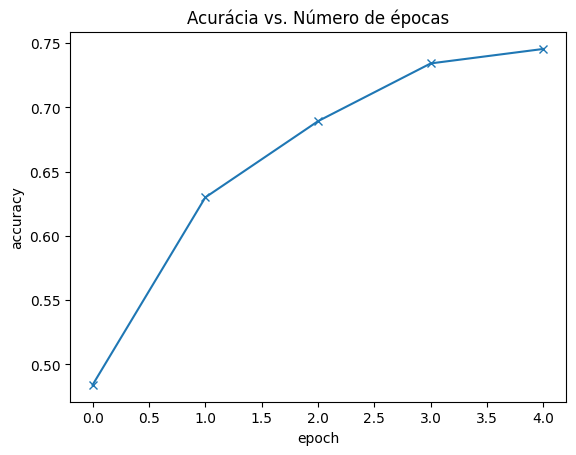

In [39]:
plot_accuracies(history)

In [40]:
def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Treino", "Validação"])
    plt.title("Perda vs. Número de épocas")

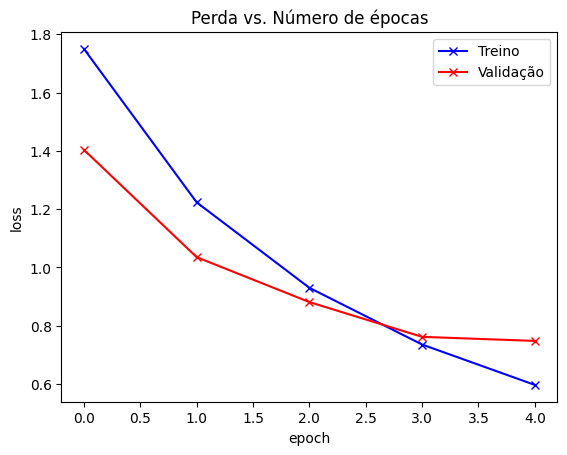

In [41]:
plot_losses(history)

In [42]:
def predict_image(img, model):
    # Converter em um tensor
    xb = to_device(img.unsqueeze(0), device)
    # Obter previsão de tensor
    yb = model(xb)
    # Escolher o rótulo com maior probabilidade
    _, preds = torch.max(yb, dim=1)
    # Obter o rótulo
    return dataset.classes[preds[0].item()]

Label: automobile , Predicted: automobile


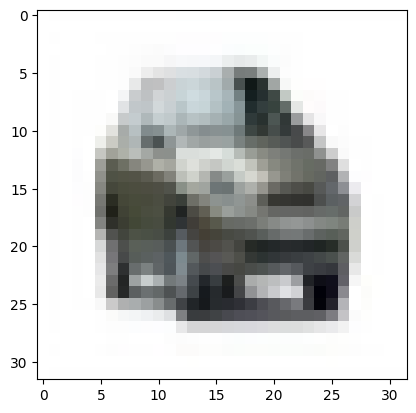

In [48]:
img, label = dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

In [49]:
test_loader = DeviceDataLoader(DataLoader(dataset, BATCH_SIZE * 2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.4957493245601654, 'val_acc': 0.8256416916847229}